### PSATITP

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

from data_import import import_precipitation_ts, get_plants
from data_analysis import  is_stationary, plot_acf_pacf, precipitation_plots
from prediction import split_train_test_by_size, cross_validation, test

### Importing data

In [2]:
ts_dict = import_precipitation_ts()
plants = get_plants()
plant_on_analysis = "PSATITP"

### Data Analysis


In [ ]:
precipitation_plots(ts_dict, plant_on_analysis)

In [ ]:
is_stationary(ts_dict, "PSATITP")

In [ ]:
plot_acf_pacf(ts_dict, "PSATITP")

### Preparing Data for Prediction

In [3]:
df = ts_dict[plant_on_analysis].dropna(axis=0)
X_train, X_test, y_train, y_test = split_train_test_by_size(df, 100)

In [4]:
dfcg = df.copy()
c = pd.read_csv(f"../data/ts-{plant_on_analysis}-cfs-model.csv", index_col=[0])
g = pd.read_csv(f"../data/ts-{plant_on_analysis}-gefs-model.csv", index_col=[0])
dfcg = pd.concat([dfcg, c, g], axis=1).dropna(axis=0)
X_cg_train, X_cg_test, y_cg_train, y_cg_test = split_train_test_by_size(dfcg)

In [5]:
mask = np.ones(X_train.shape[1], dtype=bool)
mask[30:45] = False
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

### Hyperparameters search

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
param_grid_knn = {
    'n_neighbors': range(1, 15),
    'p': [1, 2, 3],
}

grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'n_neighbors': 14, 'p': 3}

In [8]:
param_grid_rf = {
    'n_estimators': [20, 50, 80, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 4, 'n_estimators': 200}

In [9]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=tscv, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

In [ ]:
grid_search_knn_cg = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn_cg.fit(X_cg_train, y_cg_train)
best_params_knn_cg = grid_search_knn_cg.best_params_
best_params_knn_cg

In [ ]:
grid_search_rf_cg = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf_cg.fit(X_cg_train, y_cg_train)
best_params_rf_cg = grid_search_rf_cg.best_params_
best_params_rf_cg

In [ ]:
grid_search_xgb_cg = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=tscv, n_jobs=-1, verbose=1)
grid_search_xgb_cg.fit(X_cg_train, y_cg_train)
best_params_xgb_cg = grid_search_xgb_cg.best_params_
best_params_xgb_cg

### Models

In [21]:
knn = KNeighborsRegressor(**best_params_knn)
rf = RandomForestRegressor(**best_params_rf, criterion="squared_error", random_state=0)
xgb = XGBRegressor(**best_params_xgb)

### Prediction without cfs and gefs

In [ ]:
cross_validation(knn, X_train, y_train)

In [ ]:
cross_validation(rf, X_train, y_train)

Evaluation 0
Evaluation 1
Evaluation 2
Evaluation 3
Evaluation 4
Evaluation 5
Evaluation 6
Evaluation 7
Evaluation 8
Evaluation 9


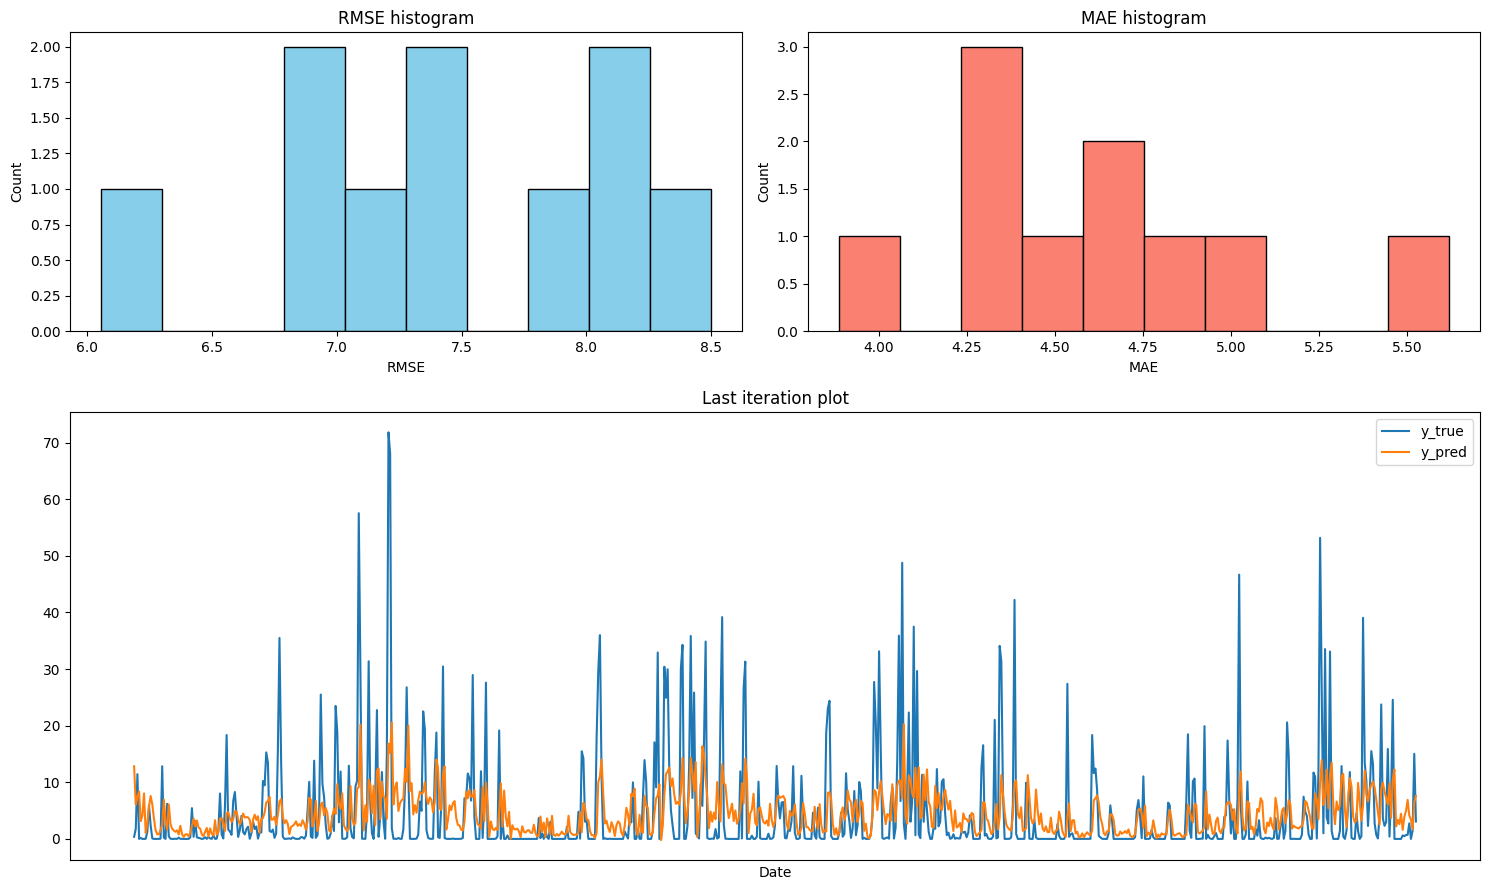

In [23]:
cross_validation(xgb, X_train, y_train)

### Prediction with cfs and gefs

In [ ]:
cross_validation(knn, X_traincg, y_traincg)

In [ ]:
cross_validation(rf, X_traincg, y_traincg)

In [ ]:
cross_validation(xgb, X_traincg, y_traincg)

### Test scores

#### Without cfs and gefs

In [14]:
test(knn, X_train, X_test, y_train, y_test)

Test RMSE: 4.34
Test  MAE: 3.32


In [15]:
test(rf, X_train, X_test, y_train, y_test)

Test RMSE: 4.11
Test  MAE: 3.17


In [16]:
test(xgb, X_train, X_test, y_train, y_test)

Test RMSE: 3.98
Test  MAE: 2.98


#### With cfs and gefs

In [54]:
test(knn, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.759999772250188


In [55]:
test(rf, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.1857706478512


In [57]:
test(xgb, X_traincg, X_testcg, y_traincg, y_testcg)

Test RMSE: 4.294003083625308
